# Deep Learning Assessment 1

login: ab2533

### Imports

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import utils
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold

2023-02-24 21:28:03.379327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-24 21:28:03.379354: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Model Parameters Definition

In [2]:
# No of output classes in the fashion mnist dataset
N_CLASSES = 10

# optimizer used for learning training paremters
OPTIMIZER = Adam() 

# input image shape
INPUT_SHAPE = (28, 28, 1)

# No of epoch for training
N_EPOCH = 5

# batch size for training
BATCH_SIZE = 128

# No of folds for cross validation
N_FOLDS = 5

VERBOSE = 1

# proportion of the dataset used for validation, with remaining .8 for training
VALIDATION_SPLIT=0.2  

# Conv layer 1 parameters
NUM_FILTERS1 = 64
KERNEL_SIZE1 = 3
STRIDE1 = 1
PAD1 = "same"

# Max Pooling layer size
POOL_SIZE = (2,2)

# Conv layer 2 parameters
NUM_FILTERS2 = 128
KERNEL_SIZE2 = 5
STRIDE2 = 1
PAD2 = "valid"

# Dense layer 1 parameters
DENSE_UNITS1 = 512

# Dense layer 2 parameters
DENSE_UNITS2 = N_CLASSES

# Loss function
LOSS_FUNCTION = 'categorical_crossentropy'

# Activation function for CNN layers 1, 2 and Dense layer 1
ACTIVATION_LAYERS = "relu"

# Activation function for output dense layer
ACTIVATION_OUTPUT = "sigmoid"

# Regularizers

KERNEL_REG = regularizers.L1L2(l1=1e-5, l2=1e-4)
BIAS_REG = regularizers.L1(1e-5)

plt.style.use('ggplot')

### Import Data + Normalise Pixel Values

In [3]:
(X_train_t, y_train), (X_test_t, y_test) = fashion_mnist.load_data()

In [4]:
# normalisation of the pixel values from 0-255 range to 0-1 range 
X_train = X_train_t / 255
X_test = X_test_t / 255

In [5]:
print("Shape of input training data: " + str(X_train.shape))
print("Shape of the output training data: " + str(y_train.shape))
print("Shape of the input test data: " + str(X_test.shape))
print("Shape of the output test data: " + str(y_test.shape))

Shape of input training data: (60000, 28, 28)
Shape of the output training data: (60000,)
Shape of the input test data: (10000, 28, 28)
Shape of the output test data: (10000,)


### Visualize Random Image

Sample input image: [[0.         0.         0.         0.         0.         0.
  0.         0.         0.08235294 0.9372549  0.78823529 0.78823529
  0.83137255 0.59607843 0.64705882 0.82352941 0.8        0.78823529
  0.75294118 0.81568627 0.05882353 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.29803922 0.8627451  0.78039216 0.77254902
  0.77254902 0.89019608 1.         0.85098039 0.77254902 0.7254902
  0.74901961 0.81568627 0.25490196 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.45882353 0.85098039 0.75294118 0.8
  0.74117647 0.83137255 0.85490196 0.78823529 0.8        0.76078431
  0.74117647 0.82352941 0.38823529 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.    

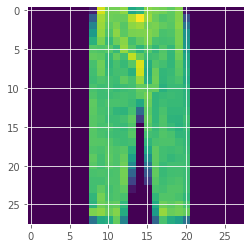

In [6]:
import random
import matplotlib.pyplot as plt

image_ind = random.randint(0, 59999)
random_image = X_train[image_ind]
print ("Sample input image: " + str(random_image))
plt.imshow(random_image)
plt.show() 

### One-Hot Encoding of Outputs

In [7]:
y_train = utils.to_categorical(y_train, N_CLASSES)
y_test = utils.to_categorical(y_test, N_CLASSES)

### Define CNN Model Architecture

In [8]:
def get_cnn_model_architecture(display_summary=False):
    cnn_model = Sequential()

    # Conv layer 1
    cnn_model.add(Conv2D(filters=NUM_FILTERS1, kernel_size=KERNEL_SIZE1, strides=STRIDE1, padding=PAD1, input_shape=INPUT_SHAPE, kernel_regularizer=KERNEL_REG, bias_regularizer=BIAS_REG))
    cnn_model.add(Activation(ACTIVATION_LAYERS))

    # Pooling Layer
    cnn_model.add(MaxPooling2D(pool_size=POOL_SIZE))

    # Conv layer 2              
    cnn_model.add(Conv2D(filters=NUM_FILTERS2, kernel_size=KERNEL_SIZE2, strides=STRIDE2, padding=PAD2, kernel_regularizer=KERNEL_REG, bias_regularizer=BIAS_REG))
    cnn_model.add(Activation(ACTIVATION_LAYERS))

    # Flatten output of Conv layer for providing as input to Dense layer
    cnn_model.add(Flatten())

    # Dense layer 1
    cnn_model.add(Dense(units=DENSE_UNITS1, kernel_regularizer=KERNEL_REG, bias_regularizer=BIAS_REG))
    cnn_model.add(Activation(ACTIVATION_LAYERS))

    # Dense layer 2
    cnn_model.add(Dense(units=DENSE_UNITS2, kernel_regularizer=KERNEL_REG, bias_regularizer=BIAS_REG))
    cnn_model.add(Activation(ACTIVATION_OUTPUT))


    cnn_model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])
    
    # display model output `display_summary` flag is true
    if display_summary:
        cnn_model.summary()
        
    return cnn_model

In [9]:
get_cnn_model_architecture(True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 activation (Activation)     (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 128)       204928    
                                                                 
 activation_1 (Activation)   (None, 10, 10, 128)       0         
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                        

2023-02-24 21:28:05.564187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-24 21:28:05.564211: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-24 21:28:05.564239: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter): /proc/driver/nvidia/version does not exist
2023-02-24 21:28:05.564454: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Merge Train and Test Data

In [10]:
X_data = np.concatenate((X_train, X_test))
y_data = np.concatenate((y_train, y_test))

### Model Training with Cross-Validation 

In [11]:
kf = KFold(N_FOLDS, shuffle=True, random_state=1)

train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []

for i, (train_index, test_index) in enumerate(kf.split(X_data, y_data)):
    
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Validation:  index={test_index}")
    
    X_train_fold = X_data[train_index]
    y_train_fold = y_data[train_index]
    X_test_fold = X_data[test_index]
    y_test_fold = y_data[test_index]
    
    # build new cnn model for each fold
    cnn_model = get_cnn_model_architecture()
    
    history_fold = cnn_model.fit(X_train_fold, y_train_fold, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE)
    score_train_fold = cnn_model.evaluate(X_train_fold, y_train_fold, batch_size=BATCH_SIZE, verbose=VERBOSE)
    score_test_fold = cnn_model.evaluate(X_test_fold, y_test_fold, batch_size=BATCH_SIZE, verbose=VERBOSE)
    
    train_loss.append(score_train_fold[0])
    train_accuracy.append(score_train_fold[1])
    test_loss.append(score_test_fold[0])
    test_accuracy.append(score_test_fold[1])
    

Fold 0:
  Train: index=[    0     1     2 ... 69995 69997 69999]
  Validation:  index=[   10    12    14 ... 69993 69996 69998]
Epoch 1/5
438/438 [==============================] - 51s 114ms/step - loss: 0.7503 - accuracy: 0.8377
Epoch 2/5
438/438 [==============================] - 37s 85ms/step - loss: 0.4752 - accuracy: 0.8894
Epoch 3/5
438/438 [==============================] - 37s 84ms/step - loss: 0.4134 - accuracy: 0.9022
Epoch 4/5
438/438 [==============================] - 35s 81ms/step - loss: 0.3833 - accuracy: 0.9106
Epoch 5/5
110/110 [==============================] - 3s 23ms/step - loss: 0.3607 - accuracy: 0.9166
Fold 1:
  Train: index=[    0     1     3 ... 69997 69998 69999]
  Validation:  index=[    2     8    13 ... 69986 69989 69990]
Epoch 1/5
438/438 [==============================] - 35s 78ms/step - loss: 0.7778 - accuracy: 0.8506
Epoch 2/5
438/438 [==============================] - 34s 78ms/step - loss: 0.4255 - accuracy: 0.8978
Epoch 3/5
438/438 [==================

### Visualize Accuracy and Loss of Model in Each Fold

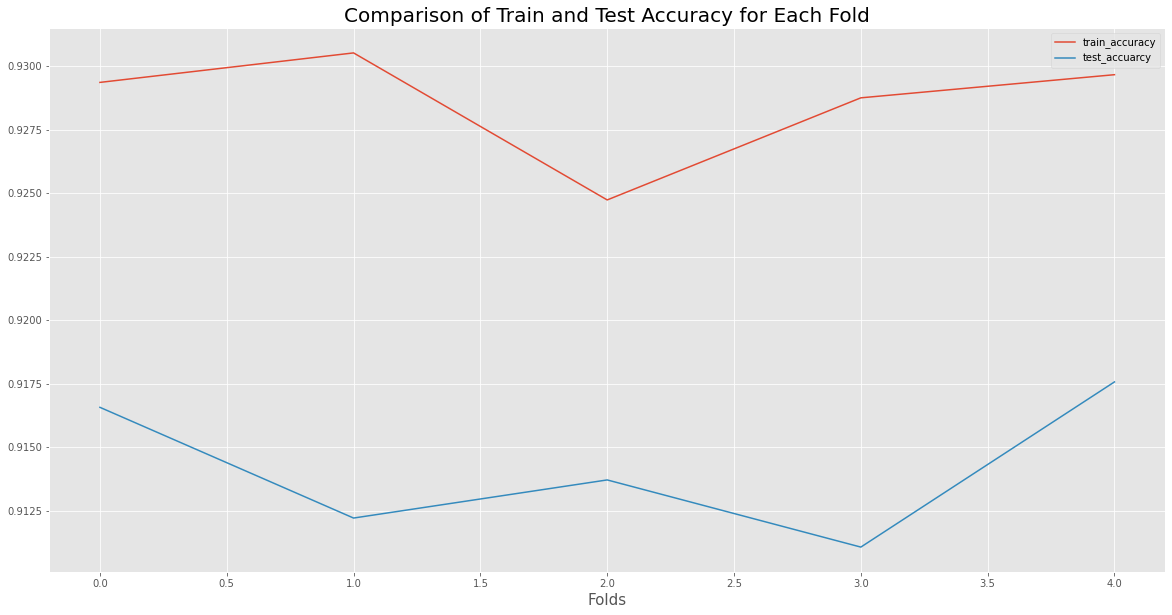

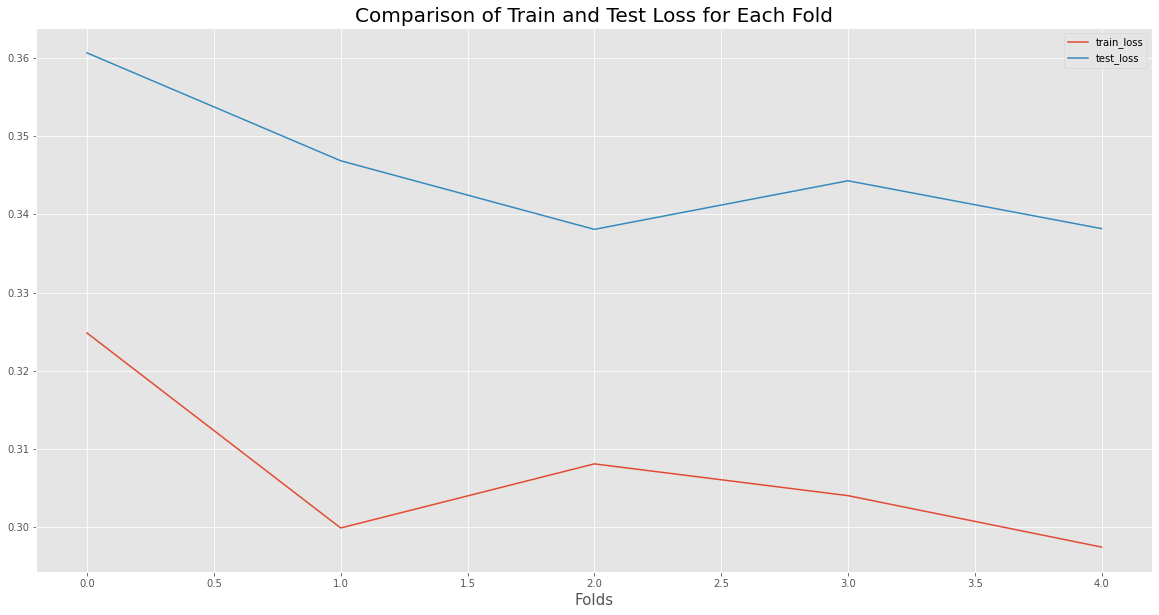

In [12]:

plt.figure(1, figsize=(20,10))
plt.title('Comparison of Train and Test Accuracy for Each Fold', fontsize=20)
plt.plot(range(N_FOLDS), train_accuracy, label='train_accuracy')
plt.plot(range(N_FOLDS), test_accuracy, label='test_accuarcy')
plt.xlabel('Folds', fontsize=15)
plt.legend()
plt.show()

plt.figure(2, figsize=(20,10))
plt.title('Comparison of Train and Test Loss for Each Fold', fontsize=20)
plt.plot(range(N_FOLDS), train_loss, label='train_loss')
plt.plot(range(N_FOLDS), test_loss, label='test_loss')
plt.xlabel('Folds', fontsize=15)
plt.legend()
plt.show()

In [13]:
print("Average Train Accuarcy of {} folds: {}\n".format(N_FOLDS, np.mean(train_accuracy)))
print("Average Test Accuarcy of {} folds: {}\n".format(N_FOLDS, np.mean(test_accuracy)))
print("Average Train Loss of {} folds: {}".format(N_FOLDS, np.mean(train_loss)))
print("Average Test Loss of {} folds: {}".format(N_FOLDS, np.mean(test_loss)))

Average Train Accuarcy of 5 folds: 0.9286035776138306

Average Test Accuarcy of 5 folds: 0.9142285704612731

Average Train Loss of 5 folds: 0.306828773021698
Average Test Loss of 5 folds: 0.34563068151473997


***** 
The model trained above achieves a reasonably good test accuracy. The cross validation assures that the model is not biased towards a certain chunk of data. In addition regularization is applied to prevent the model from overfitting.

Following are some of the suggestions for improving the performance further:
1. Additional Conv and Dense Layer can be added to the model architecture with appropriate parameters (filters, kernel size, stride, padding, number of dense units etc)
2. Dropout can be added to prevent model overfitting and allow it to generalize so that it can perform well on unseen data.
3. Additional Model Optimizers can be tried to see if performance is improved further.
4. Hyperparameter Tuning can be used to build multiple models with different combinations of hyper-parameters (filters, kernel size, stride, padding, number of dense units, regularization_parameters etc) and then select the model with the best performance.

